## Example 06 - Visualizing the sailed path

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime
import platform
import random
import os

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# tranport network analysis package
import transport_network_analysis.core as core

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

# Graph location
location_graph = "Shape-Files/Rotterdam-Antwerpen-corridor"
name_graph = "edges_2.shp"

### Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

**Important**: 

If you use windows and get the following error "ImportError: read_shp requires OGR: http://www.gdal.org/", you probably have [this issue](https://github.com/conda-forge/gdal-feedstock/issues/219). Solving it is possible by running the following commands in your terminal (as explained [here](https://gis.stackexchange.com/questions/294231/installing-gdal-with-anaconda)):

```bash
#Create a new virtual environment
conda create -n testgdal -c conda-forge gdal vs2015_runtime=14

#Activate virtual environment
activate testgdal

#Open Jupyter notebook
jupyer notebook
```

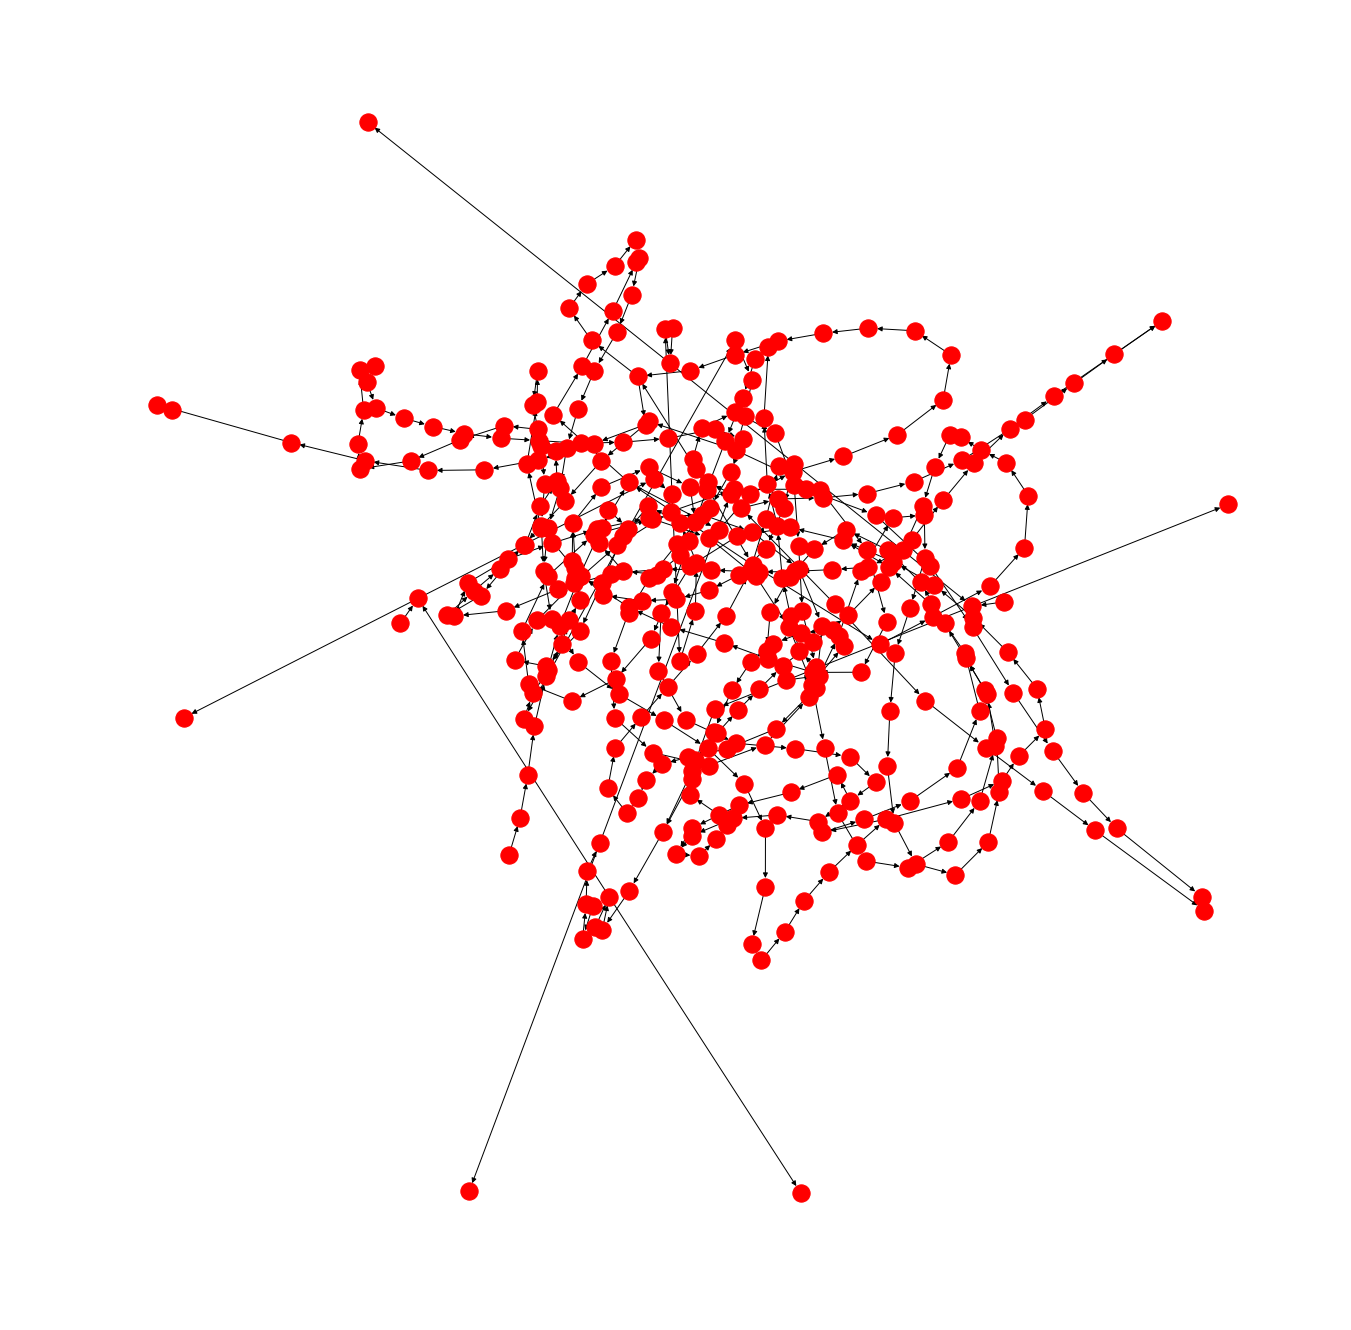

In [2]:
# Read the shape-file
FG = nx.read_shp(os.path.join(location_graph, name_graph), 
                 simplify=True)

# Draw the shape-file to get a first impression
plt.figure(figsize=(18,18))
nx.draw(FG)

# Show the drawing
plt.show()

In [3]:
for i, node in enumerate(FG.nodes(data = True)):
    print(node)
    print(nx.info(FG))
    print(nx.info(FG, FG[i]))
    break

((4.2319184, 51.441247), {})
Name: 
Type: DiGraph
Number of nodes: 409
Number of edges: 416
Average in degree:   1.0171
Average out degree:   1.0171


KeyError: 0

In [4]:
for i in FG.nodes():
    print(FG[i])
    break

{(4.2318401, 51.4416226): {'fid': 1.0, 'osm_id': 182720993, 'name': 'Schelde-Rijnkanaal', 'type': 'canal', 'width': None, 'ShpName': 'edges_2', 'Wkb': b'\x00\x00\x00\x00\x02\x00\x00\x00\x02@\x10\xed|\x04]\\\xd2@I\xb8z\xc8\x1d:\xa3@\x10\xedg}\xbd\x9b\x01@I\xb8\x87\x16\xe0\x16V', 'Wkt': 'LINESTRING (4.2319184 51.441247,4.2318401 51.4416226)', 'Json': '{ "type": "LineString", "coordinates": [ [ 4.2319184, 51.441247 ], [ 4.2318401, 51.4416226 ] ] }'}}


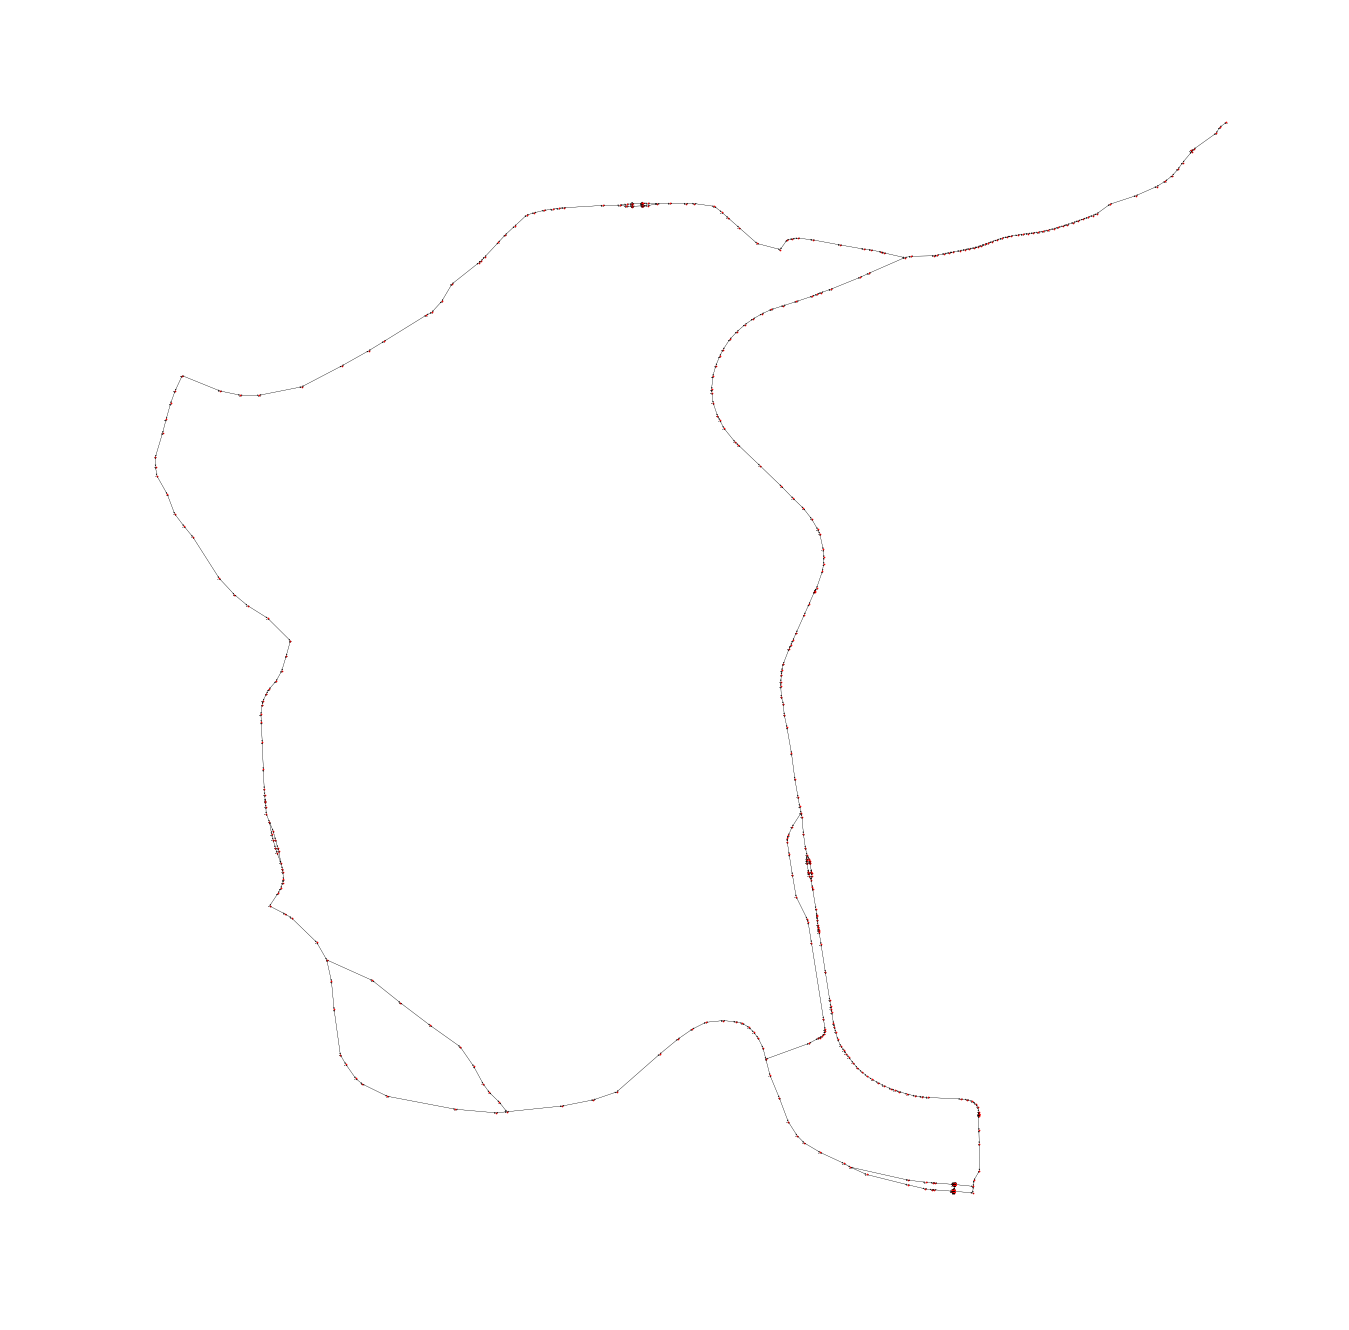

In [42]:
# calculate distance between two points
def calculate_distance(orig, dest):
    wgs84 = pyproj.Geod(ellps='WGS84')
    
    distance = wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                         shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2]
    
    return distance

H_G = nx.Graph()

lat_lon_to_index = {}
edge_id_counter = 0

for i, node in enumerate(FG.nodes(data = True)):
    H_G.add_node(i, pos = node[0], 
                    name = "Node {}".format(i),
                    geometry = shapely.geometry.Point(node[0][0], node[0][1]))
    lat_lon_to_index[node[0]] = i

    
for edge in FG.edges(data=True): 
    H_G.add_edge(lat_lon_to_index[edge[0]], 
                 lat_lon_to_index[edge[1]],
                 dis= calculate_distance(nx.get_node_attributes(H_G, 'geometry')[lat_lon_to_index[edge[1]]], 
                                         nx.get_node_attributes(H_G, 'geometry')[lat_lon_to_index[edge[0]]]))

FG = H_G.to_directed()
plt.figure(figsize=(18,18))
nx.draw(FG, nx.get_node_attributes(FG, 'pos'), with_labels=True, node_size=0.5, font_size = 2, width = 0.2, arrowsize = 3)
plt.show()

### Create vessels
Vessel without graph, but with shortest path.

In [43]:
# Make a class out of mix-ins
TransportResource = type('TransportResource', 
                         (core.Identifiable, core.Log, core.ContainerDependentMovable, 
                          core.HasResource, core.Routeable), {})



# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

data_vessel = {"env": None,
               "name": "Vessel number 1",
               "route": None,
               "geometry": shapely.geometry.Point(0, 0),  # lon, lat
               "capacity": 1_000,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}

# create the transport processing resource
vessel = TransportResource(**data_vessel)

### Define paths

In [44]:
# First simulation is from random node 1 to random node 2
random_1 = random.choice(list(FG))
random_2 = random.choice(list(FG))

path_1 = nx.dijkstra_path(FG, random_1, random_2)
print(path_1)

[369, 370, 371, 376, 377, 321, 322, 323, 333, 334, 397, 398, 399, 196, 197, 198, 319, 368, 260, 261, 262, 311, 312, 390, 391, 392, 78, 77, 76, 339, 58, 57, 56, 381, 201, 200, 199, 406, 327, 326, 215, 214, 213, 362, 204, 203, 202, 408, 407, 299, 298, 297, 293, 292, 291, 355, 177, 176, 175, 212, 211, 8, 7, 6, 375, 5, 4, 3, 22, 21, 189, 361, 360, 149, 148, 147, 151, 188, 187, 385, 384, 142, 93, 92, 91, 186, 185, 283, 284, 359, 18, 19, 20, 239, 150, 85, 86, 87, 257, 344, 282, 256, 145, 143, 144, 313, 88, 89]


In [45]:
# First simulation is from random node 1 to random node 2
random_1 = random.choice(list(FG))
random_2 = random.choice(list(FG))

path_2 = nx.dijkstra_path(FG, random_1, random_2)
print(path_2)

[396, 25, 24, 23, 389, 219, 120, 119, 47, 43, 41, 42, 66, 67, 68, 69, 70, 106, 107, 108, 349, 350, 153]


In [46]:
paths = [path_1, path_2]

### Run simulation

In [47]:
def start(env, vessel):
    while True:
        vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
        yield from vessel.move()
        vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        
        if vessel.geometry == nx.get_node_attributes(FG, "geometry")[vessel.route[-1]]:
            break

In [48]:
for path in enumerate(paths):
    # Start simpy environment
    env = simpy.Environment()
    
    # Add graph to environment
    env.FG = FG
    
    # Add environment and path to the vessel
    vessel.env = env
    vessel.route = path[1]

    # Start the simulation
    env.process(start(env, vessel))
    env.run()

    print("Simulation of path {} took {} seconds".format(path[0] + 1, int(env.now)))

Simulation of path 1 took 38844 seconds
Simulation of path 2 took 3919 seconds


### Testing
With v = 1 the distance of a path should be equal to the simulation time.

If simulation time == distance of path, test succeeds.

In [49]:
wgs84 = pyproj.Geod(ellps='WGS84')
distance_path_1 = 0
distance_path_2 = 0

for node in enumerate(path_1):
    orig = nx.get_node_attributes(FG, "geometry")[path_1[node[0]]]
    dest = nx.get_node_attributes(FG, "geometry")[path_1[node[0] + 1]]

    distance_path_1 += int(wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                                     shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2])
    
    if node[0] + 2 == len(path_1):
                break

for node in enumerate(path_2):
    orig = nx.get_node_attributes(FG, "geometry")[path_2[node[0]]]
    dest = nx.get_node_attributes(FG, "geometry")[path_2[node[0] + 1]]

    distance_path_2 += int(wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                                     shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2])
    
    if node[0] + 2 == len(path_2):
                break

In [50]:
distance_path_1, distance_path_2

(38793, 3910)

### Visualization of path

In [51]:
for key in dict(FG.nodes):
    FG.nodes[key]["Path"] = 0.5
    FG.nodes[key]["Color"] = "Red"
    for i, node in enumerate(path_1):
        if key == node:
            if i == 0:
                FG.nodes[key]["Path"] = 200
                FG.nodes[key]["Color"] = "Green"
            elif i == len(path_1) - 1:
                FG.nodes[key]["Path"] = 200
                FG.nodes[key]["Color"] = "Green"
            else:
                FG.nodes[key]["Path"] = 50
                FG.nodes[key]["Color"] = "Green"
                break

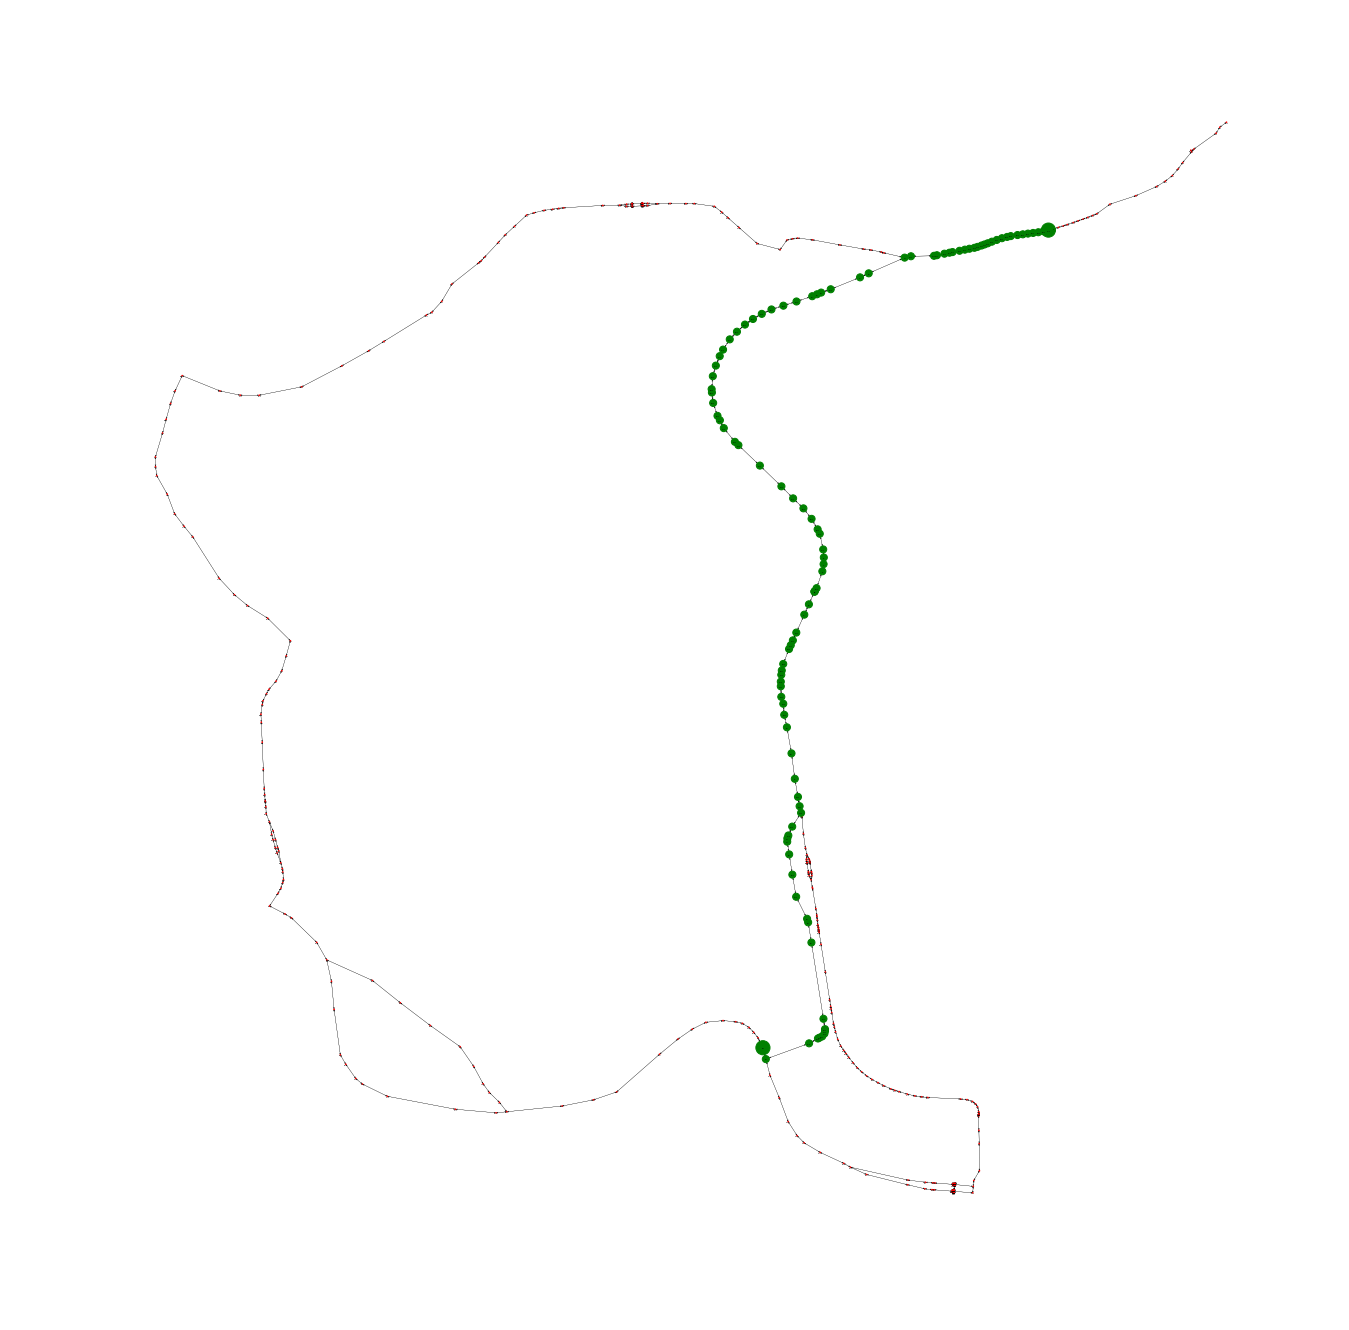

In [52]:
plt.figure(figsize=(18,18))
nx.draw(FG, nx.get_node_attributes(FG, 'pos'), 
        with_labels = True, 
        node_size = list(dict(nx.get_node_attributes(FG, 'Path')).values()), 
        font_size = 2, 
        node_color = list(dict(nx.get_node_attributes(FG, 'Color')).values()), 
        width = 0.2, 
        arrowsize = 3)
plt.show()

### Vessel logs